# High PM2.5, Who are the culprits ?

There are four major theories regarding the source air pollution: (1) the source is local: at beginning of winter 2019 the government thought that winter air pollution is naturally occur [temperature inversion effect](https://sciencing.com/effects-temperature-inversion-8447465.html), when the cold air along with the pollution is trapped closed to the earth surface. At point point the government blamed emission from old diesel engines are to blame. (2) Some people blame the agricultural burning, which maybe from local area and surrounded provinces. Winter is the time with a lot of open agricultural burning activities though out the country. Some officials actually try to tackle the air pollution by reducing open burning activities. (3) the source is not local: there are air pollution from other provinces or countries. Some NGOs blame the pollution of near by power plants. 

My analysis procedure is the following. Build a machine learning model(ML) to predict the air pollution level in Bangkok using environmental factor such as weathers, fire maps, and traffic index. Date-time feature such as local hour, and week of year are included in the model to capture other effects from human activities. Interpret contribution to the pollution using the feature of importances provided by the ML model.


If the pollution is from local pollutions then the high AQI should depend on weather pattern such as wind speed, humidity, average temperature, local traffic, and hour of the day. But if the pollution is from agricultural burning the amount of pollution will depends on existence of the active fires with some time lag. The fire activities are included based on the distance from Bangkok. However, if the sources of the pollution is not from the fire map, then the model should consider that weather pattern, such as wind direction and wind speed more importance factors.  

Here are a list of features to consider and their sources: 
- Weather pattern: temperature, wind speed, humidity, and rain, which scrape from [Weather Underground website](thtps://www.wunderground.com/history/daily/th).
- Traffic index from [Longdo Traffic](http://traffic.longdo.com/trafficindex), hour of day, and holiday pattern 
- Active fire information from NASA's [FIRMS](https://firms.modaps.eosdis.nasa.gov) project.


There are some technical aspects to considers. First, what models should I use? Many time series predictions, such as stock markets, employ ARIMA and LSTM models. I believe this method is not suitable here because these models try to predict the future value from the past value (please correct me if I am wrong). Here, I aim to find the contribution factors. Still, care much be taken during the train/test split to prevent spilling over. Second, I can model the pollution change instead of the absolute number. I have tried this approach, but the model has low accuracy. Alternatively, I can turn this problem into a classification problem, which I have tried, but again I didn't get a very good result. Third, I can try to model the daily average PM 2.5 level instead of an hourly average. If I use the daily average, then information about local traffic would be average out; therefore, I will use the hourly data. 

In short, I am going to build a model to perform hourly prediction of PM 2.5 particle. 


In [1]:
# import the library
import sys
import feather
from pathlib import Path
sys.path.append(r'C:\Users\Benny\fastai\old')

%config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from fastai.io import *
from fastai.dataset import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

from IPython.display import display

import seaborn as sns

# Loading Data, Visualization and Feature Engineer 


1. PM2.5 data, and BKK neighbor provinces
2. Weather data: temperature, wind speed, humidity, and rain, which scrape from [Weather Underground website](thtps://www.wunderground.com/history/daily/th)
3. Active fire map from NASA's [FIRMS](https://firms.modaps.eosdis.nasa.gov) project.
4. Traffic index from [Longdo Traffic](http://traffic.longdo.com/trafficindex) measured hourly


## 1. PM2.5 data, and BKK neighbor provinces

Load PM2.5 data for all regions, combine with regional information, keep only Bangkok and the neighbor provinces with < 200 km away.

In [304]:
# load the regional information with latitude and longitude information in 
# mercadian coordinate
region_df = pd.read_csv('data/model/region_info.csv',sep=';')
#convert the unit to km
region_df['x_mer'] = region_df['x_mer']/1000
region_df['y_mer'] = region_df['y_mer']/1000
region_df['dis2BKK'] = region_df['dis2BKK']/1000

In [305]:
region_df.sort_values('dis2BKK').head()

,City,Region,Population,Latitude,Longitude,x_mer,y_mer,dis2BKK
0,Bangkok,Bangkok,5104476,13.7540,100.5014,11187.764672,1544.967921,0.000000
1,Bang Kruai,Nonthaburi,78305,13.8050,100.4728,11184.580935,1550.778546,6.625674
37,Phra Pradaeng,Samut Prakan,171333,13.6585,100.5336,11191.349160,1534.090704,11.452615
25,Mueang Nonthaburi,Nonthaburi,291555,13.8607,100.5148,11189.256353,1557.126140,12.249384
31,Pak Kret,Nonthaburi,182926,13.9130,100.4988,11187.475241,1563.087681,18.122072


There is a little confusion in the city and region columns. City in fact refer to a subprovince and region actually refer to the province. In this record, most regions have one city in it, but a few regions have 2 - 3 cities.  

In [306]:
# select provinces, which is less than 200 km away 
region_df = region_df.query('dis2BKK < 200')

In [307]:
# read the air pollution data for all province
pm25_all = pd.read_csv('data/model/pm25_all.csv')
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])
# merge with the region
pm25_all = pm25_all.merge(region_df, left_on=['city'], right_on='City')
pm25_all.set_index('Time',inplace=True)

In [308]:
# select pm2.5 data in provinces, which is less than 200 km away
# generate the province list
provinceslist = region_df['Region'].values
# keep BKK neighbor
pm25_all = pm25_all[pm25_all['Region'].isin(provinceslist)]
# drop the city, City columns
pm25_all = pm25_all.drop(['city','City'],axis=1)

In [309]:
# put the pm2.5 into category and color for visualizing purpose
pm25_all['level'] = pd.cut(pm25_all['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate','unhealthy'],
                      include_lowest=True, right=False)
pm25_all['color'] = pd.cut(pm25_all['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])

# create time features 
pm25_all['day'] = pm25_all.index.day 
pm25_all['date'] = pm25_all.index.date
pm25_all['quarter'] = pm25_all.index.quarter
pm25_all['month'] = pm25_all.index.month
pm25_all['DayofYear'] = pm25_all.index.dayofyear
pm25_all['DayofWeek'] = pm25_all.index.dayofweek
pm25_all['weekofyear'] = pm25_all.index.weekofyear
pm25_all['TimeofDay'] = pm25_all.index.time

pm25_all['is_weekend'] = pm25_all.index.dayofweek.isin([5,6])*1

pm25_all['month-year'] = pm25_all.index.strftime('%b-%Y')
pm25_all['season'] = 'other'
pm25_all.loc[pm25_all['month'].isin([12,1,2]),'season'] ='winter'

In [310]:
pm25_all.describe()

,PM2.5,Population,Latitude,Longitude,x_mer,y_mer,dis2BKK,day,quarter,month,DayofYear,DayofWeek,weekofyear,is_weekend
count,641359.000000,6.413590e+05,641359.000000,641359.000000,641359.000000,641359.000000,641359.000000,641359.000000,641359.000000,641359.000000,641359.000000,641359.000000,641359.000000,641359.000000
mean,25.437474,3.009747e+05,13.721813,100.506176,11188.296310,1541.388345,71.552658,15.719043,2.504264,6.532424,183.427101,2.965754,26.520161,0.275842
std,15.546214,9.596860e+05,0.594225,0.473714,52.733619,67.667218,47.465694,8.776074,1.119287,3.432222,104.972110,1.984841,14.950607,0.446938
min,1.000000,5.045600e+04,12.570700,99.548300,11081.666065,1410.501300,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,14.500000,5.776100e+04,13.536700,100.122200,11145.552321,1520.224488,29.248499,8.000000,1.000000,3.000000,91.000000,1.000000,13.000000,0.000000
50%,21.300000,7.830500e+04,13.805000,100.533600,11191.349160,1550.778546,69.825095,16.000000,3.000000,7.000000,183.000000,3.000000,26.000000,0.000000
75%,32.200000,1.185510e+05,14.004100,100.795400,11220.492602,1573.475216,109.861641,23.000000,4.000000,10.000000,274.000000,5.000000,39.000000,1.000000
max,714.900000,5.104476e+06,14.798100,101.648300,11315.436996,1664.190781,169.023405,31.000000,4.000000,12.000000,366.000000,6.000000,52.000000,1.000000


Obtain Thailand holiday information from https://www.timeanddate.com/holidays/thailand/

In [469]:
years = ['2016','2017','2018','2019']
holiday = pd.DataFrame()
for year in years:
    url = 'https://www.timeanddate.com/holidays/thailand/' + year
    df = pd.read_html(url)[0]
    df['Date'] = year + ' ' +df['Date']
    holiday = pd.concat([holiday,df])
    

In [470]:
holiday.columns = [name1 for name1,name2 in holiday.columns]

In [471]:
holiday['Date'] = pd.to_datetime(holiday['Date'], format='%Y %b %d')
holiday = holiday[holiday['Holiday Type'] == 'National holiday']
holiday.head()

,Date,Weekday,Holiday Name,Holiday Type
0,2016-01-01,Friday,New Year's Day,National holiday
7,2016-02-22,Monday,Makha Bucha,National holiday
9,2016-04-06,Wednesday,Chakri Day,National holiday
10,2016-04-13,Wednesday,Songkran,National holiday
11,2016-04-14,Thursday,Songkran,National holiday


In [213]:
holiday.to_csv('holiday.csv',index=False)

In [311]:
holiday = pd.read_csv('holiday.csv')
# add holiday columns into the pm25 table 
pm25_all['is_holiday'] = pm25_all.index.isin(holiday['Date'])*1

In [312]:
pm25_all.head()

,PM2.5,Region,Population,Latitude,Longitude,x_mer,y_mer,dis2BKK,level,color,...,quarter,month,DayofYear,DayofWeek,weekofyear,TimeofDay,is_weekend,month-year,season,is_holiday
Time,,,,,,,,,,,,,,,,,,,,,
2016-03-03 15:00:00,62.9,Bangkok,5104476,13.754,100.5014,11187.764672,1544.967921,0.0,unhealthy,red,...,1,3,63,3,9,15:00:00,0,Mar-2016,other,0
2016-03-03 16:00:00,62.9,Bangkok,5104476,13.754,100.5014,11187.764672,1544.967921,0.0,unhealthy,red,...,1,3,63,3,9,16:00:00,0,Mar-2016,other,0
2016-03-03 17:00:00,55.5,Bangkok,5104476,13.754,100.5014,11187.764672,1544.967921,0.0,unhealthy,orange,...,1,3,63,3,9,17:00:00,0,Mar-2016,other,0
2016-03-03 18:00:00,55.5,Bangkok,5104476,13.754,100.5014,11187.764672,1544.967921,0.0,unhealthy,orange,...,1,3,63,3,9,18:00:00,0,Mar-2016,other,0
2016-03-03 19:00:00,47.9,Bangkok,5104476,13.754,100.5014,11187.764672,1544.967921,0.0,moderate,orange,...,1,3,63,3,9,19:00:00,0,Mar-2016,other,0


In [313]:
# save the data 
pm25_all.to_csv('data/model/pm25bkknear_proc.csv')

In [314]:
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['Time'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.set_index('Time')
bkkpm = pm25_all[pm25_all['Region'] == 'Bangkok']
nearbkkpm = pm25_all[pm25_all['Region'] != 'Bangkok']

The amount of air pollution in the next hour will depends on the amount of pollution in the previous time because the pollution will remain in the air for a while. This is captured in author correlation function and partial auto-correlation function. 

The partial auto-correlation function is the correlation with the previous time steps with the earlier effect accounted for. Looking at the partial auto-correlation function, it is sufficient to include the data from Bangkok with  one hour time lag into the model. 

In [301]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot

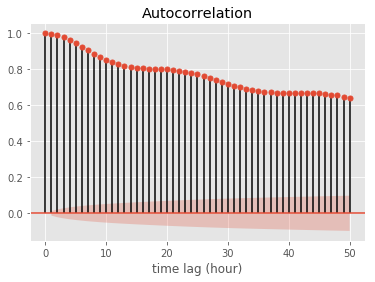

In [315]:
plot_acf(pmnear['Bangkok'], lags=50)
plt.xlabel('time lag (hour)')
pyplot.show()

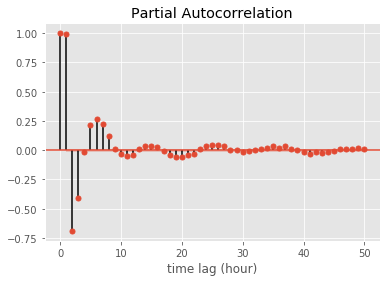

In [316]:
plot_pacf(pmnear['Bangkok'], lags=50)
plt.xlabel('time lag (hour)')
pyplot.show()

## 2. Weather data

I wrote a program to scrape weather data from Weather Underground. It is stored in the data/weather folder. After putting all the files into a DataFrame, I convert the unit to SI unit, and explore different between the weather pattern in winter (with high pollution) and in other season. I put all features into the model, and drop the features. At the end, I use Humidity, and Wind speed. 


In [443]:
# load the data from all files
weather_f = glob('data/weather/weather_*.csv')
weather = pd.DataFrame()
for file in weather_f:
    weather = pd.concat([weather,pd.read_csv(file)])
weather = weather.drop('Unnamed: 0',axis=1)
weather=weather.sort_values('date')

In [444]:
# convert F to C,  mph to kmh and in to mm 
weather['Temperature(C)'] = (weather['Temperature(F)'] - 32)*5/9
weather['Dew Point(C)'] = (weather['Dew Point(F)'] - 32)*5/9
weather['Wind Speed(kmh)'] = weather['Wind Speed(mph)'] * 1.609344 

In [445]:
weather['Condition'].unique()

array(['Fair', 'Partly Cloudy', 'Fog', 'Mostly Cloudy', 'Light Rain', 'Showers in the Vicinity',
       'Heavy Rain Shower', 'Heavy T-Storm', 'Light Rain with Thunder', 'Light Rain Shower', 'Haze',
       'T-Storm', 'Rain', 'Smoke', 'Light Rain / Windy', 'Thunder in the Vicinity', 'Fair / Windy',
       'Heavy Rain', 'Partly Cloudy / Windy', 'T-Storm / Windy', 'Heavy T-Storm / Windy', 'Rain / Windy',
       'Thunder', 'Rain Shower', 'Light Drizzle', 'Heavy Rain Shower / Windy', 'Mist',
       'Mostly Cloudy / Windy', 'Rain Shower / Windy', 'Cloudy', 'Light Rain Shower / Windy',
       'Heavy Rain / Windy'], dtype=object)

In [446]:
weather['Wind'].unique()

array(['NE', 'NNE', 'E', 'ENE', 'N', 'NNW', 'CALM', 'SSE', 'VAR', 'ESE', 'NW', 'SE', 'WNW', 'S', 'SW', 'WSW',
       'W', 'SSW', nan], dtype=object)

Condition and Wind columns are description of the weather. I extract the key words such as if it rain (humidity and water help reduce the pollution). Calm wind is going to make the pollution worse because the existing pollution would add to the newly generated pollution.  

In [447]:
# extract key words and turn it into new columns
weather['is_rain'] = weather['Condition'].str.contains('Rain|Drizzle|Thunder|Storm|Shower')*1
weather['is_fair'] = weather['Condition'].str.contains('Fair')*1
weather['is_cloudy'] = weather['Condition'].str.contains('Cloudy')*1
weather['is_fog'] = weather['Condition'].str.contains('Fog|Mist')*1
weather['is_windy'] = weather['Condition'].str.contains('Windy')*1

# drop emperial unit columns 
weather = weather.drop(['Temperature(F)', 'Dew Point(F)',
       'Wind Speed(mph)', 'Wind Gust(mph)', 'Pressure(in)', 'Precip.(in)',
       'Precip Accum(in)','Time'],axis=1)

In [186]:
weather.columns

Index(['Humidity(%)', 'Wind', 'Condition', 'date', 'Temperature(C)',
       'Dew Point(C)', 'Wind Speed(kmh)', 'is_rain', 'is_fair', 'is_cloudy',
       'is_fog', 'is_windy', 'is_calm'],
      dtype='object')

In [187]:
# save for later use 
weather.to_csv('data//model/weatherall.csv',index=False)

### Explore Weather Data

In [461]:
# Load the data
weather = pd.read_csv('data/model/weatherall.csv').dropna()
weather['date'] = pd.to_datetime(weather['date'])
weather = weather.set_index('date').sort_index()
# look at difference between winter and not winter
weather['season'] = 'other'
weather.loc[np.isin(weather.index.month, [12, 1, 2]), 'season'] = 'winter'
weather[['Wind', 'Condition', 'season', 'is_rain', 'is_fair',
         'is_cloudy', 'is_fog', 'is_windy', 'is_calm']] = weather[['Wind', 'Condition', 'season', 'is_rain', 'is_fair', 'is_cloudy', 'is_fog', 'is_windy', 'is_calm']].astype('category')

Text(0.5, 0, '')

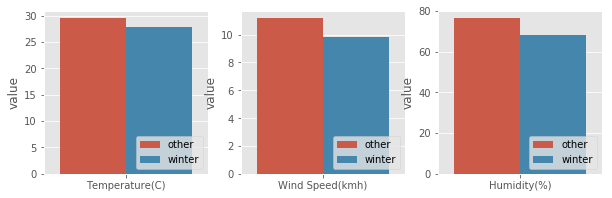

In [378]:
# explore difference between winter and other season
season = weather[['Temperature(C)','Wind Speed(kmh)','Humidity(%)',
         'season']].groupby('season',as_index=False).mean()

season = pd.melt(season,id_vars='season')

fig = plt.figure(figsize=(10,3))
ax1 = fig.add_subplot(131)
data= season[season['variable']=='Temperature(C)']
sns.barplot(data=data,x='variable',y='value',hue='season')
plt.legend(loc='lower right')
plt.xlabel('')

ax2 = fig.add_subplot(132)
data= season[season['variable']=='Wind Speed(kmh)']
sns.barplot(data=data,x='variable',y='value',hue='season')
plt.legend(loc='lower right')
plt.xlabel('')

ax3 = fig.add_subplot(133)
data= season[season['variable']=='Humidity(%)']
sns.barplot(data=data,x='variable',y='value',hue='season')
plt.legend(loc='lower right')
plt.xlabel('')


In [356]:
season.head()

,season,variable,value
0,other,Temperature(C),29.450150
1,winter,Temperature(C),27.804020
2,other,Wind Speed(kmh),11.159669
3,winter,Wind Speed(kmh),9.829937
4,other,Humidity(%),76.224405


Temperature, wind speed, and humidity decreases in winter, but how does this change with the PM2.5 particle? 

### Relationship with the PM 2.5 particles

Explore relationship between weather pattern and the level of PM2.5 particles

In [596]:
# load pm2.5 data
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['datetime'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.drop('Time',axis=1)
pm25_all = pm25_all.set_index('datetime')
bkkpm = pm25_all.loc[pm25_all['Region'] == 'Bangkok',['PM2.5','level','color']]

In [463]:
# merge with weather data by datetime
pm_weather = weather.merge(bkkpm,how='right',left_index=True,right_index=True)
pm_weather = pm_weather.sort_index()

In [464]:
pm_weather.shape, pm_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24454 entries, 2016-03-03 15:00:00 to 2019-03-20 20:00:00
Data columns (total 16 columns):
Humidity(%)        24341 non-null float64
Wind               24341 non-null category
Condition          24341 non-null category
Temperature(C)     24341 non-null float64
Dew Point(C)       24341 non-null float64
Wind Speed(kmh)    24341 non-null float64
is_rain            24341 non-null category
is_fair            24341 non-null category
is_cloudy          24341 non-null category
is_fog             24341 non-null category
is_windy           24341 non-null category
is_calm            24341 non-null category
season             24341 non-null category
PM2.5              24454 non-null float64
level              24454 non-null object
color              24454 non-null object
dtypes: category(9), float64(5), object(2)
memory usage: 1.7+ MB


((24454, 16), None)

I make the data less crowd, I am going to look at the data during January - March 2018. This is the period with both low and high pollution levels, but is stil in winter season.

In [384]:
cols = pm_weather.columns[:12].values
cols

array(['Humidity(%)', 'Wind', 'Condition', 'Temperature(C)', 'Dew Point(C)', 'Wind Speed(kmh)', 'is_rain',
       'is_fair', 'is_cloudy', 'is_fog', 'is_windy', 'is_calm'], dtype=object)

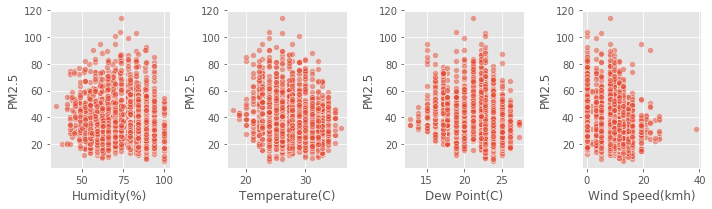

In [467]:
# explore a specific time with low and high PM
data = pm_weather['2018-01-01':'2018-03-31']
fig, ax = plt.subplots(1,4,figsize=(10,3))
ax = ax.flat
idxs = [0,3,4,5]
for i,idx  in enumerate(idxs):
    sns.scatterplot(data=data, x= cols[idx],y='PM2.5',
                    ax=ax[i],alpha=0.5, legend=False ) 

plt.tight_layout()

There are some relationship between the weather pattern and PM2.5 level, but very noisy ones. The PM 2.5 is low for high humidity, high temperature, and wind speed.

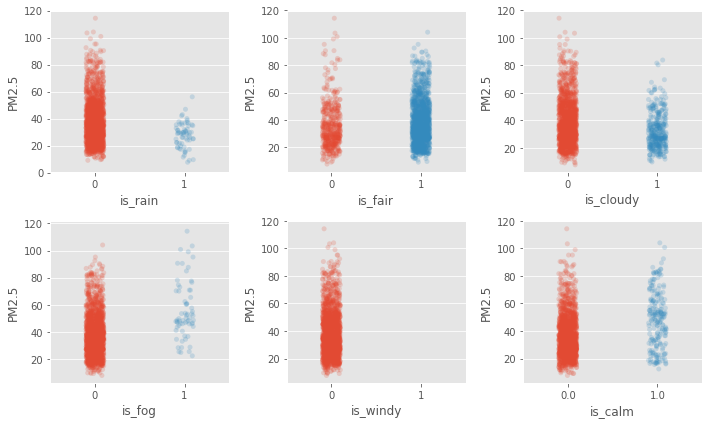

In [469]:
# explore a specific time with low and high PM
fig, ax = plt.subplots(2,3,figsize=(10,6))
ax = ax.flat
conditions = cols[-6:]
for i,con  in enumerate(conditions):
    sns.catplot(data=data, x= con, y='PM2.5',alpha=0.2, legend=False,ax=ax[i] ) 
    plt.close(2)

plt.tight_layout()

Rain seem to be the only condition with less pollution. No different for other conditions. This means we only need the rain column. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 <a list of 18 Text xticklabel objects>)

<Figure size 288x288 with 0 Axes>

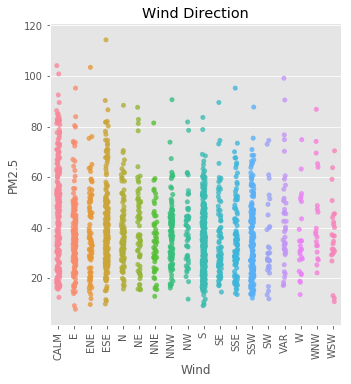

In [480]:
# explore a specific time with low and high PM
fig = plt.figure(figsize=(4,4))
sns.catplot(data=data, x= 'Wind', y='PM2.5',alpha=0.8, legend=False) 
plt.title('Wind Direction')
plt.xticks(rotation = 90)

In summary, I will keep the following columns: 'Temperature(C)', 'Humidity(%)',
'Wind Speed(kmh)', and 'is_rain' columns.

## 3. Fire Map

NASA's Fire Information for Resource Management System (FIRM) monitors a real time fire activity with satellite.

Some information about the data. NASA's Fire Information for Resource Management System (FIRMS) provides nea real-time, world-wide, fire map of anomalous fire activities using VIIRS measurements and MODIS measurement from two satellites named Aqua and Terra.

The data composed of the following columns [reference](https://earthdata.nasa.gov/what-is-new-collection-6-modis-active-fire-data):
- Central of the fire (1 km resolution): 'latitude', 'longitude' 
- Date and Time:'acq_date','acq_time' in UTC, 'DayNight'
- Hotspots temperature:  'brightness'and 'brightness_t31' in Kelvin (different channels of measurements) 
- FRP: fire radiative power in MW

- Confidence: Confidence estimates range between 0 and 100% and are assigned one of the three fire classes (low-confidence fire, nominal-confidence fire, or high-confidence fire) only for the MODIS measurement.

other infos 

- actual pixel size is shown in 'Scan' and 'Track'

I reqested the data for Thailand, Laos, Cambodia, Myanmar. 

In [706]:
fire = pd.DataFrame()
for filename in glob('data/fire_map/*.csv'):
    fire = pd.concat([fire,pd.read_csv(
        filename,usecols=[0,1,2,5,6,12], skiprows=1,header=None)],sort=False)

fire.columns= ['latitude', 'longitude','brightness','acq_date','acq_time','power']
fire['acq_time'] = fire['acq_time'].astype(int)
fire = fire.sort_values(['acq_date','acq_time','latitude','longitude'])
# data for each region will include record from the neighbor countries
# so need to drop duplicate records
fire = fire.drop_duplicates()

In [707]:
fire.head(), fire.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1836287 entries, 417 to 13563
Data columns (total 6 columns):
latitude      float64
longitude     float64
brightness    float64
acq_date      object
acq_time      int32
power         float64
dtypes: float64(4), int32(1), object(1)
memory usage: 91.1+ MB


(     latitude  longitude  brightness    acq_date  acq_time  power
 417   11.6499   105.5782       324.1  2016-01-01       343   16.0
 311   11.7085   105.6405       317.5  2016-01-01       343    7.5
 310   11.7101   105.6301       340.1  2016-01-01       343   42.1
 309   11.7133   105.6370       333.1  2016-01-01       343   28.4
 308   11.7150   105.6266       334.9  2016-01-01       343   31.2, None)

In [491]:
# function to change latitude and longitude to Mercator coordinate system 
#from https://wiki.openstreetmap.org/wiki/Mercator
import math

def merc_x(lon):
  r_major = 6378137.000 # unit:meter
  return r_major*math.radians(lon)

def merc_y(lat):
    lat += 0.08
    if lat>89.5:lat=89.5
    if lat<-89.5:lat=-89.5
    r_major=6378137.000
    r_minor=6356752.3142
    temp=r_minor/r_major
    eccent=math.sqrt(1-temp**2)
    phi=math.radians(lat)
    sinphi=math.sin(phi)
    con=eccent*sinphi
    com=eccent/2
    con=((1.0-con)/(1.0+con))**com
    ts=math.tan((math.pi/2-phi)/2)/con
    y=0-r_major*math.log(ts)
    return y

In [708]:
#conver to mercator coordinate
fire['x_mer']= fire.longitude.apply(merc_x)
fire['y_mer']= fire.latitude.apply(merc_y)

#calculate distance from BKK
fire['dis2BKK'] = ((fire.x_mer - 11187764.6720111)**2 +(fire.y_mer - 1544967.92056433)**2)**0.5

#assemble datetime column \
fire['datetime'] = fire['acq_date'].astype(str) + ' ' + fire['acq_time'].astype(str)
fire['datetime'] = pd.to_datetime(fire['datetime'],format='%Y-%m-%d %H%M',utc=True)

#convert to Bangkok time zone and remove time zone information
fire['datetime'] = fire['datetime'].dt.tz_convert('Asia/Bangkok')
fire['datetime'] = fire['datetime'].dt.tz_localize(None)
fire = fire.sort_values('datetime')

fire = fire.drop('acq_time',axis=1)

In [709]:
fire.to_csv('data/model/thfire.csv',index=False)

### Visualize hot spots

In [527]:
from bokeh.io import output_file, output_notebook, show,curdoc, reset_output,export_png
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, Circle, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, CategoricalColorMapper, Slider, DateRangeSlider,
    DateSlider, SingleIntervalTicker, LinearAxis,Legend, LegendItem, Label
)
from bokeh.models.markers import Asterisk
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import Viridis5
from bokeh.plotting import figure, show, output_file
from bokeh.tile_providers import STAMEN_TERRAIN,CARTODBPOSITRON_RETINA
from bokeh.layouts import widgetbox,row, column, gridplot


In [710]:
fire = pd.read_csv('data/model/thfire.csv')
fire = fire.drop(['latitude','longitude'],axis=1)
fire['datetime'] = pd.to_datetime(fire['datetime'])
fire.set_index('datetime',inplace=True)
fire.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1836287 entries, 2016-01-01 10:43:00 to 2019-03-26 02:12:00
Data columns (total 6 columns):
brightness    float64
acq_date      object
power         float64
x_mer         float64
y_mer         float64
dis2BKK       float64
dtypes: float64(5), object(1)
memory usage: 98.1+ MB


In [500]:
fire.head()

,brightness,acq_date,power,x_mer,y_mer,dis2BKK
datetime,,,,,,
2016-01-01 10:43:00,324.5,2016-01-01,15.3,1.175787e+07,1.403848e+06,587306.986758
2016-01-01 10:43:00,316.8,2016-01-01,7.5,1.181783e+07,1.410751e+06,644205.206732
2016-01-01 10:43:00,320.4,2016-01-01,13.1,1.170214e+07,1.486954e+06,517635.144566
2016-01-01 10:43:00,319.2,2016-01-01,10.5,1.169999e+07,1.487284e+06,515463.275554
2016-01-01 10:43:00,314.2,2016-01-01,4.6,1.162152e+07,1.565573e+06,434245.530471


In [501]:
output_notebook()

Loading BokehJS ...

In [560]:
[[bkk_x, bkk_y]]= region_df.query('City == "Bangkok"')[['x_mer','y_mer']].values*1000
stepx = 3.5E5
stepy = 1*stepx

The picture below compare the hot spots on Jan 08, 2018 with low PM2.5 level(green), Feb 08, 2018 with high PM2.5 level(red), and off winter season May 5, 2018. Clearly, the number of hot spots are less on the day with less pollution, and the number of hot spots is much lower in winter season. These hot spots are from agricultural burning

Since the PM2.5 particle is an average over 24 hours, and the average wind speed is 10 km/hour. This mean, the fire from as far as 240 km will contribute to the current PM2.5 level. This means the hot spots with in the yellow circle, in the previous 24 hours will contribute to the current PM2.5. 240 km cover a large area all the way to Myanmar and Cambodia. Furthermore, the hot pots as far as 480 km away will reach Bangkok on the next day. 

In [583]:
day3 = '2018-01-08' 
day = '2018-02-08'
day2 = '2018-05-08'

# define the map size the map is in meter unit 
p = figure(x_range=(bkk_x-stepx, bkk_x+stepx), y_range=(bkk_y-stepy, bkk_y+stepy),
               x_axis_type="mercator", y_axis_type="mercator", 
               title='Fire Map 2018', plot_width=500, plot_height=500,
           toolbar_location=None)
# add terrian map
p.add_tile(STAMEN_TERRAIN)

# add 10 kmline
p.line(x=[bkk_x + 0.1*stepx, bkk_x + 0.1*stepx +100E3] , y= [bkk_y - 0.7*stepy,bkk_y - 0.7*stepy],
      color='black',line_width=2)
# add 10 km text
kmline = Label(x=bkk_x + 0.15*stepx, y=bkk_y - 0.7*stepy,
                 text='100 km')
p.add_layout(kmline)

# add 240 km circle
p.circle(x=bkk_x,y=bkk_y, size=300, color='yellow', alpha=0.4)

#  Bangkok location          
glyph = Asterisk(x=bkk_x,y=bkk_y, size=8, line_color='black')
p.add_glyph(glyph) 

# Data on 8 Feb
source = ColumnDataSource(fire[day])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='red',
           legend='8 Feb 2018')

# Data on 8 Jan
source = ColumnDataSource(fire[day3])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='green',
           legend='8 Jan 2018')

# Data on 8 May
source = ColumnDataSource(fire[day2])
p.triangle(source=source,x='x_mer',y='y_mer', size=4, color='blue',
           legend='8 May 2018')


p.legend.location = "bottom_left"


show(p)

In [584]:
export_png(p, filename="firemap2018.png")

'C:\\Users\\Benny\\Documents\\Fern\\BKK-AQI\\firemap2018.png'

To include the fire map into the model. I select the hot spots within the 240 km radius from Bangkok. Find the total sum for that particular hours. Shift the data by 12 hours, which is the average time lag for the 240 km radius data. Then, take the total sum over the 24 hours window. The same treatment is applied to  the hot spots in 240 - 480 km radius, and 480 - 720 km radius with different time lag.

In [711]:
# find active fire with in 240 km from bkk 
fireclose = fire[fire['dis2BKK'].values < 240000]
# sum all the active fire in the same hour 
firehourly240 = fireclose.resample('H').agg({'power':['sum']})
firehourly240.columns = ['pwsum240']
# shift the data by 12 hours
firehourly240 = firehourly240.shift(12)
# create a 24 hour rolling sum 
firehourlyroll240 = firehourly240.rolling(window=24).sum().dropna()

In [712]:
# find active fire with in 480 km from bkk 
fireclose48 = fire.query('240000 < dis2BKK < 480000')
# sum all the active fire in the same hour 
firehourly480 = fireclose48.resample('H').agg({'power':['sum']})
firehourly480.columns = ['pwsum480']
# shift by 36 hours time lag 
firehourly480 = firehourly480.shift(36)
#  24 hours sum
firehourlyroll480 = firehourly480.rolling(window=24).sum().dropna()

In [713]:
# find active fire with in 720 0 from bkk 
fireclose72 = fire.query('480000 < dis2BKK < 720000')
#fireclose72 = fire[fire['dis2BKK'].values < 720000]
firehourly720 = fireclose72.resample('H').agg({'power':['sum']})
firehourly720.columns = ['pwsum720']
# shift by 12 + 48 hours time lag 
firehourly720 = firehourly720.shift(60)
# 24 hours sum
firehourlyroll720 = firehourly720.rolling(window=24).sum().dropna()

In [714]:
# load pm2.5 data
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['datetime'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.drop('Time',axis=1)
pm25_all = pm25_all.set_index('datetime')
bkkpm = pm25_all.loc[pm25_all['Region'] == 'Bangkok',['PM2.5','level','color']]

In [715]:
# merge the fire data into a single df and combine with pm2.5 data for exploration
merge_list = [firehourlyroll240, firehourlyroll480, firehourlyroll720]

for df in merge_list:
    bkkpm = bkkpm.merge(df,left_index=True,
                                    right_index=True, how='left' )

In [621]:
bkkpm.head()

,PM2.5,level,color,pwsum240,pwsum480,pwsum720
datetime,,,,,,
2016-03-03 15:00:00,62.9,unhealthy,red,4143.6,28437.3,19270.0
2016-03-03 16:00:00,62.9,unhealthy,red,4143.6,28437.3,19270.0
2016-03-03 17:00:00,55.5,unhealthy,orange,4143.6,28437.3,19270.0
2016-03-03 18:00:00,55.5,unhealthy,orange,4143.6,28437.3,19270.0
2016-03-03 19:00:00,47.9,moderate,orange,4143.6,28437.3,19270.0


In [622]:
bkkpm.columns

Index(['PM2.5', 'level', 'color', 'pwsum240', 'pwsum480', 'pwsum720'], dtype='object')

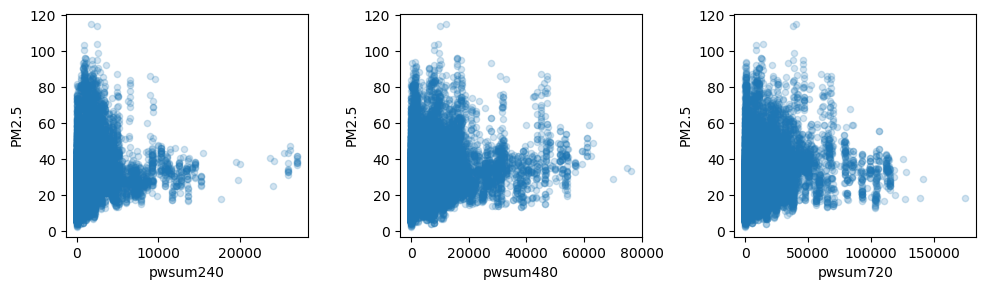

In [739]:
cols = ['pwsum240', 'pwsum480', 'pwsum720']

fig,axs = plt.subplots(1,3,figsize=(10,3))
axs = axs.reshape(-1)
for i, col in enumerate(cols):
    bkkpm.plot(x=col,y='PM2.5',ax=axs[i],kind='scatter', alpha=0.2)

plt.tight_layout()

Text(0.5, 0, 'total fire power within 240 km')

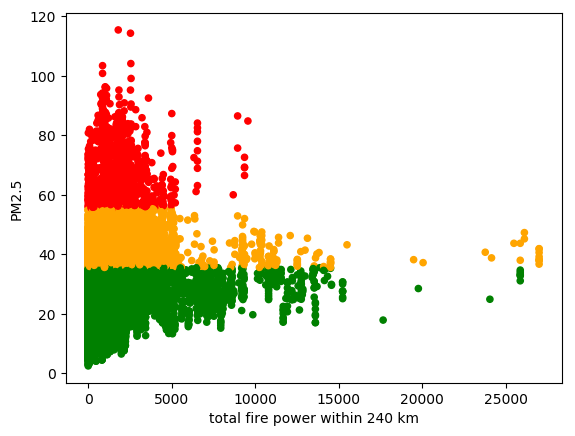

In [738]:
bkkpm.plot(x='pwsum240',y='PM2.5',color=bkkpm['color'],kind='scatter')
plt.xlabel('total fire power within 240 km')

The relationship is clearer when plotting in a log scale.

In [719]:
bkkpm[['log(1+pwsum240)', 'log(1+pwsum480)', 'log(1+pwsum720)']]= np.log(1+bkkpm[cols])

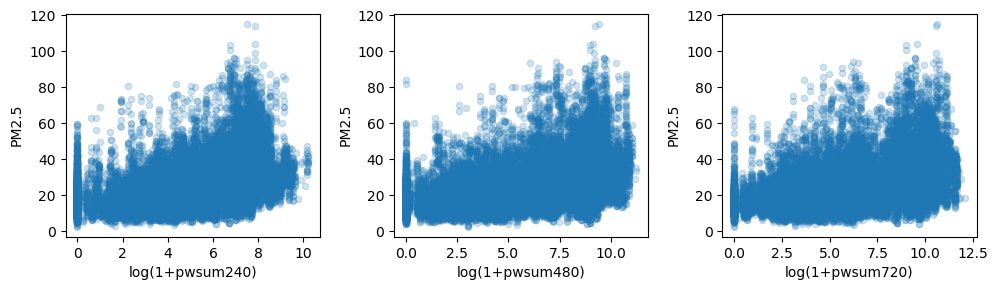

In [740]:
cols = ['log(1+pwsum240)', 'log(1+pwsum480)', 'log(1+pwsum720)']

fig,axs = plt.subplots(1,3,figsize=(10,3))
axs = axs.reshape(-1)
for i, col in enumerate(cols):
    bkkpm.plot(x=col,y='PM2.5',ax=axs[i],kind='scatter', alpha=0.2)
plt.tight_layout()

Text(0.5, 0, 'log (1+total fire in 240 km)')

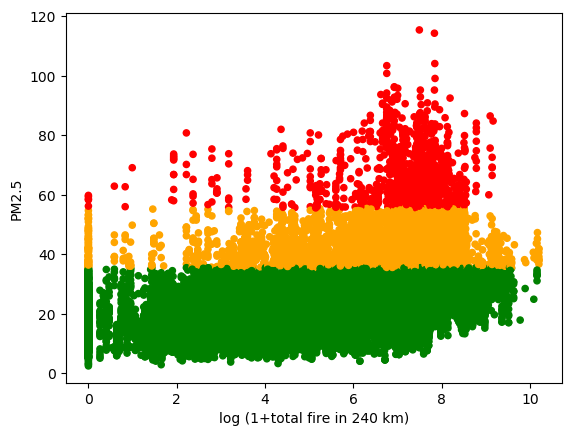

In [737]:
bkkpm.plot(x='log(1+pwsum240)',y='PM2.5',color=bkkpm['color'],kind='scatter')
plt.xlabel('log (1+total fire in 240 km)')

The hot spots from 240, 480, and 720 km seems to have a log relationship with the PM2.5 level. I will put them all into the models. I expected that the hot spots from further away should have less influence (lower importance). 

The fire map is very seasonal and align with the pollution seasonal pattern. 

In [736]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


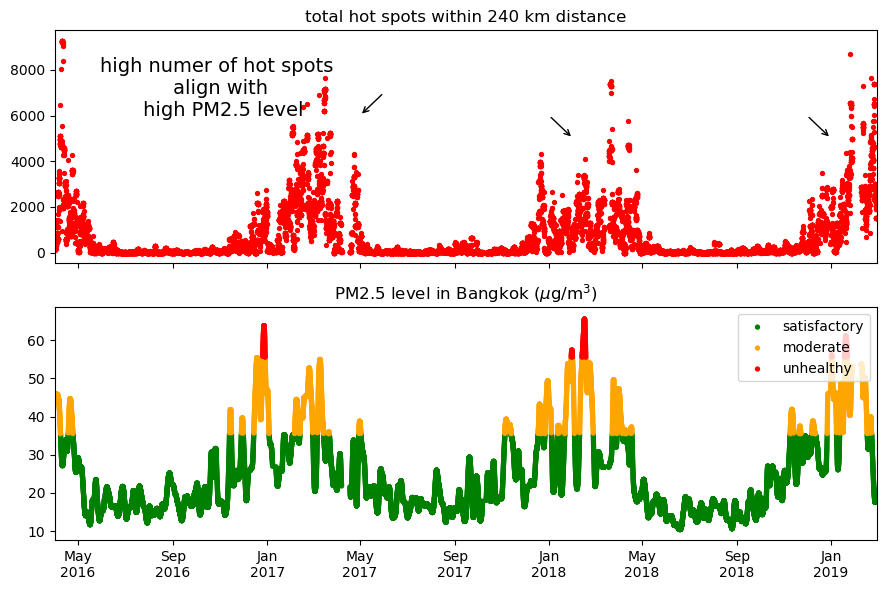

In [775]:
import matplotlib.dates as mdates

temp = bkkpm['2016-04':'2019-02']
temp['color'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['green', 'orange','red'])
temp['level'] = pd.cut(temp['PM2.5'],bins = [0, 35.5, 55.5, 150.4], 
                       labels=['satisfactory', 'moderate', 'unhealthy'])

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(9, 6),sharex=True)

ax1.scatter(x=temp.index,y=temp['pwsum240'],s=8,c='red')
ax1.set_title("total hot spots within 240 km distance")
plt.xlim(temp.index.min(), temp.index.max())

ax1.text('2016-11', 6000, 'high numer of hot spots \n align with \n high PM2.5 level',
         {'color': 'k', 'fontsize': 14, 'ha': 'center'})
ax1.annotate("", xy=('2017-05',6000),xytext=('2017-06',7000),arrowprops=dict(arrowstyle="->"))
ax1.annotate("", xy=('2018-02',5000),xytext=('2018-01',6000),arrowprops=dict(arrowstyle="->"))
ax1.annotate("", xy=('2019-01',5000),xytext=('2018-12',6000),arrowprops=dict(arrowstyle="->"))


# make legend 
for legend in ['satisfactory', 'moderate', 'unhealthy']:
    toplot = temp[temp['level']==legend]
    # plot the data for each pollution level
    ax2.scatter(toplot.index, toplot['PM2.5'], 
                c=toplot['color'],s=8, label=legend)
    
ax2.legend(loc='upper right')
ax2.set_title("PM2.5 level in Bangkok ($\mu$g/m$^3$)")
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))

plt.tight_layout()

In [625]:
firehourlyrollall = firehourlyroll240.merge(firehourlyroll480,left_index=True,
                                    right_index=True, how='right')

firehourlyrollall = firehourlyrollall.merge(firehourlyroll720,left_index=True,
                                    right_index=True, how='right')

In [626]:
firehourlyrollall.to_csv('data/model/firehourlyroll.csv')

In [627]:
firehourlyrollall.head()

,pwsum240,pwsum480,pwsum720
datetime,,,
2016-01-04 21:00:00,954.6,5924.9,19684.5
2016-01-04 22:00:00,954.6,6450.9,14957.8
2016-01-04 23:00:00,954.6,6206.6,14957.8
2016-01-05 00:00:00,1531.6,5756.3,17748.4
2016-01-05 01:00:00,694.4,8513.9,10120.0


## 4. Traffic Data

The raw data has some mistake on the date. The have some input on 2019/12/30, which is supposed to be for 2018/12/30. This was fixed by hand.
Some data is missing. This is fixed by linear interpolation

The index seem to decrease after 2018, which is not likely from better traffic, but probably different calculation criteria. This means that the data probably not very useful. Fortunately, we can rely on other indications such as hour of day, day of week and holiday information to infer influence of traffic to PM2.5 level.

In [631]:
traffic = pd.read_csv('data/model/trafficindex.csv').drop('timestamp',axis=1)
traffic['datetime'] = pd.to_datetime(traffic['datetime'])

traffic = traffic.set_index('datetime').resample('H').mean().round(1)
traffic = traffic['2016':'2019']

In [632]:
#handle missing value by linear interpolation
traffic_proc = traffic.interpolate(method='linear')

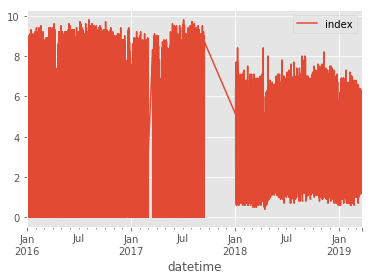

In [633]:
traffic_proc.plot()

In [634]:
traffic_proc.to_csv('data/model/traffic_proc.csv')

# Combine PM25, weather, traffic, firemap data

Using the datetime index of the PM2.5 data, I includes datetime features such as hour, dayofweek, is holiday, week of year in order to capture traffic and other human activities, which may not be included in the agricultural burning.

Additionally, the current pollution level would depends on the level in the previous hour, so I add the 24 hours rolling average of the pollution, shifted by an hour as one of the feature. Both PM2.5 levels columns are round to integer for simplicity.

In [45]:
#load the pollution data
pm25_all = pd.read_csv('data/model/pm25bkknear_proc.csv')
pm25_all['datetime'] = pd.to_datetime(pm25_all['Time'])
pm25_all = pm25_all.drop('Time',axis=1)
pm25_all = pm25_all.set_index('datetime')

# select Bangkok
bkkpm = pm25_all.loc[pm25_all['Region'] == 'Bangkok',['PM2.5','is_holiday','is_weekend','DayofWeek','weekofyear']]
#add hour of day
bkkpm['hour'] = bkkpm.index.hour

In [46]:
# make the prev level columns and shift the data by 1 hour
bkkpm['prev_level'] = bkkpm['PM2.5'].rolling(24).mean().shift(1)
bkkpm = bkkpm.dropna()
bkkpm['PM2.5'] = bkkpm['PM2.5'].round().astype(int)
bkkpm['prev_level'] = bkkpm['prev_level'].round().astype(int)

In [688]:
bkkpm.head(2)

,PM2.5,is_holiday,is_weekend,DayofWeek,weekofyear,hour,prev_level
datetime,,,,,,,
2016-03-04 16:00:00,35,0,0,4,9,16,44
2016-03-04 17:00:00,30,0,0,4,9,17,42


In [47]:
# load traffic index
traffic = pd.read_csv('data/model/traffic_proc.csv')
traffic['datetime'] = pd.to_datetime(traffic['datetime'])
traffic = traffic.set_index('datetime').resample('H').mean()
traffic.head(2)

,index
datetime,
2016-01-01 00:00:00,0.5
2016-01-01 01:00:00,0.3


In [48]:
# load hot spot data 
firehour = pd.read_csv('data/model/firehourlyroll.csv')
firehour['datetime'] = pd.to_datetime(firehour['datetime'])
firehour = firehour.set_index('datetime')
firehour =  firehour.round(2)
firehour.head(2)

,pwsum240,pwsum480,pwsum720
datetime,,,
2016-01-04 21:00:00,954.6,5924.9,19684.5
2016-01-04 22:00:00,954.6,6450.9,14957.8


In [49]:
# load the weather data
weather = pd.read_csv('data/model/weatherall.csv').dropna()
weather['date'] = pd.to_datetime(weather['date'])
weather = weather.set_index('date') 
weather[['Wind','Condition']] = weather[['Wind','Condition']].astype('category')
# keep four features 
weather = weather[['Temperature(C)', 'Humidity(%)','Wind Speed(kmh)','is_rain']]

In [50]:
weather.head(2)

,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain
date,,,,
2016-01-01 00:00:00,25.0,69,4.828032,0
2016-01-01 00:30:00,25.0,65,8.046720,0


In [51]:
# merge pm data with the weather data
bkkpm_combo = bkkpm.merge(weather, how='left',left_index=True,right_index=True)
bkkpm_combo = bkkpm_combo.sort_index()
# weather data is missing in some hour, use forward fill to fix this problem
bkkpm_combo = bkkpm_combo.fillna(method='ffill')
bkkpm_combo.shape

(24430, 11)

In [52]:
# merge with the hotspot and traffic data
bkkpm_combo = bkkpm_combo.merge(firehour, how='left',left_index=True,right_index=True)
bkkpm_combo = bkkpm_combo.merge(traffic, how='left',left_index=True,right_index=True)

In [53]:
bkkpm_combo = bkkpm_combo.dropna()

In [54]:
bkkpm_combo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24423 entries, 2016-03-04 16:00:00 to 2019-03-20 13:00:00
Data columns (total 15 columns):
PM2.5              24423 non-null int32
is_holiday         24423 non-null int64
is_weekend         24423 non-null int64
DayofWeek          24423 non-null int64
weekofyear         24423 non-null int64
hour               24423 non-null int64
prev_level         24423 non-null int32
Temperature(C)     24423 non-null float64
Humidity(%)        24423 non-null float64
Wind Speed(kmh)    24423 non-null float64
is_rain            24423 non-null float64
pwsum240           24423 non-null float64
pwsum480           24423 non-null float64
pwsum720           24423 non-null float64
index              24423 non-null float64
dtypes: float64(8), int32(2), int64(5)
memory usage: 2.8 MB


In [55]:
bkkpm_combo['Temperature(C)'] = bkkpm_combo['Temperature(C)'].round(2)
bkkpm_combo['Wind Speed(kmh)'] = bkkpm_combo['Wind Speed(kmh)'].round(2)

In [56]:
bkkpm_combo.head()

,PM2.5,is_holiday,is_weekend,DayofWeek,weekofyear,hour,prev_level,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain,pwsum240,pwsum480,pwsum720,index
2016-03-04 16:00:00,35,0,0,4,9,16,44,33.89,46.0,14.48,0.0,8651.7,26843.5,30974.5,7.1
2016-03-04 17:00:00,30,0,0,4,9,17,42,33.89,46.0,12.87,0.0,8651.7,26843.5,30974.5,8.2
2016-03-04 18:00:00,26,0,0,4,9,18,41,32.22,55.0,14.48,0.0,8651.7,26843.5,30974.5,8.8
2016-03-04 19:00:00,32,0,0,4,9,19,40,30.00,62.0,14.48,0.0,8651.7,26843.5,30974.5,8.6
2016-03-04 20:00:00,24,0,0,4,9,20,39,28.89,70.0,14.48,0.0,8651.7,26843.5,30974.5,7.3


In [57]:
# save the data
bkkpm_combo.to_csv('data/model/bkkpm_combo.csv')

after putting everything in a single dataframe, I look for the redundant features

In [2]:
# load data
bkkpm_combo = pd.read_csv('data/model/bkkpm_combo.csv')
bkkpm_combo.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
bkkpm_combo['datetime'] = pd.to_datetime(bkkpm_combo['datetime'])
bkkpm_combo.head(2)

,datetime,PM2.5,is_holiday,is_weekend,DayofWeek,weekofyear,hour,prev_level,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain,pwsum240,pwsum480,pwsum720,index
0,2016-03-04 16:00:00,35,0,0,4,9,16,44,33.89,46.0,14.48,0.0,8651.7,26843.5,30974.5,7.1
1,2016-03-04 17:00:00,30,0,0,4,9,17,42,33.89,46.0,12.87,0.0,8651.7,26843.5,30974.5,8.2


In [3]:
from scipy.cluster import hierarchy as hc

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\scipy\stats\stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


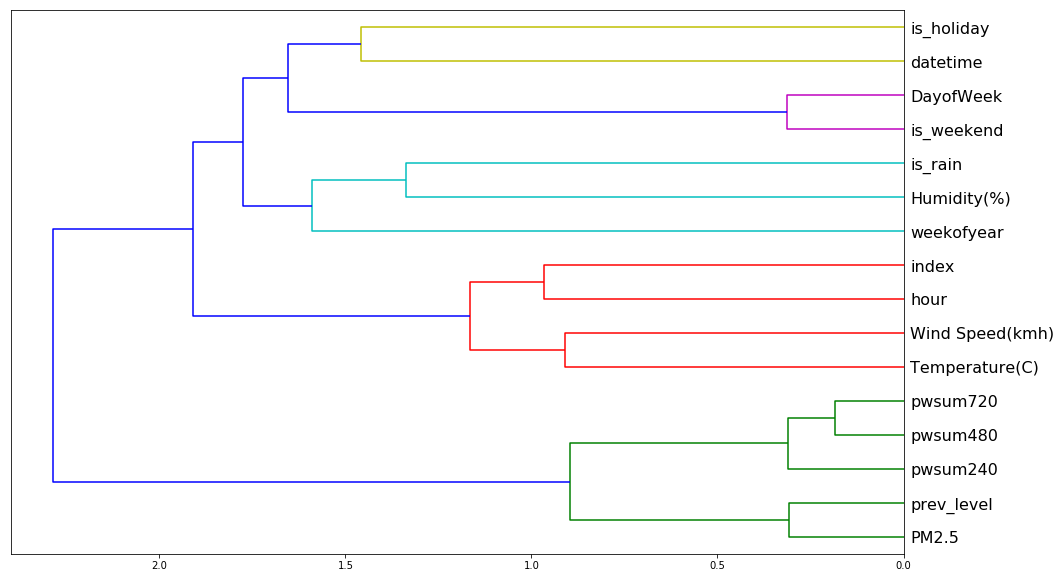

In [4]:
# Redundant Features
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(bkkpm_combo).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=bkkpm_combo.columns, orientation='left', leaf_font_size=16)
plt.show()

Traffic index and hour of day has some relationship.

## ML model 

Care must be taken when dealing with the time series data. Especially, the train-test split cannot be done with a random shuffle. The data has to be separated by time. This is how I split the data.

Test data is between 2019-02-01 to 2019-03-19. For the rest of the data, I allocate the first 80% for training and 20% for the validation. 

This is my analysis step:
1. I use random forest regression to rank most important features, drop features with low feature of important to improve the model.
2. Drop feature, which is redundant to see if the prediction accuracy improve
3. Use the final feature for auto ML to hunt for the best algorithm. (On a separate notebook)
4. Reproduce the result here, use the entire data set to train the model, calculate permutation-based feature of importances.

In [2]:
from sklearn.metrics import (classification_report, confusion_matrix,
accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score)

In [3]:
#print score print out rmse, and r2 score
def print_score(m):
    res = [mean_squared_error(m.predict(X_trn), y_trn), mean_squared_error(m.predict(X_val), y_val),
                m.score(X_trn, y_trn), m.score(X_val, y_val)]
    # if rf has bagging, print the oob score, also
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

In [133]:
# load data
bkkpm_combo = pd.read_csv('data/model/bkkpm_combo.csv')
bkkpm_combo.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
bkkpm_combo['datetime'] = pd.to_datetime(bkkpm_combo['datetime'])
bkkpm_combo.head()

,datetime,PM2.5,is_holiday,is_weekend,DayofWeek,weekofyear,hour,prev_level,Temperature(C),Humidity(%),Wind Speed(kmh),is_rain,pwsum240,pwsum480,pwsum720,index
0,2016-03-04 16:00:00,35,0,0,4,9,16,44,33.89,46.0,14.48,0.0,8651.7,26843.5,30974.5,7.1
1,2016-03-04 17:00:00,30,0,0,4,9,17,42,33.89,46.0,12.87,0.0,8651.7,26843.5,30974.5,8.2
2,2016-03-04 18:00:00,26,0,0,4,9,18,41,32.22,55.0,14.48,0.0,8651.7,26843.5,30974.5,8.8
3,2016-03-04 19:00:00,32,0,0,4,9,19,40,30.00,62.0,14.48,0.0,8651.7,26843.5,30974.5,8.6
4,2016-03-04 20:00:00,24,0,0,4,9,20,39,28.89,70.0,14.48,0.0,8651.7,26843.5,30974.5,7.3


In [20]:
print(bkkpm_combo['datetime'].min(), bkkpm_combo['datetime',].max())

2016-03-04 16:00:00 2019-03-20 13:00:00


In [134]:
bkkpm_combo.columns

Index(['datetime', 'PM2.5', 'is_holiday', 'is_weekend', 'DayofWeek',
       'weekofyear', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'is_rain', 'pwsum240', 'pwsum480', 'pwsum720',
       'index'],
      dtype='object')

In [116]:
# test index start at 
test_idx = bkkpm_combo[bkkpm_combo['datetime'] > '2019-01-31'].index[0]

In [135]:
#separate data for training and testing 
test = bkkpm_combo.iloc[test_idx:]
to_train = bkkpm_combo.iloc[:test_idx]

In [170]:
#put the training set into proc_df, indicate the target column
df, y, nas = proc_df(to_train, 'PM2.5', skip_flds=['datetime','weekofyear'])

In [137]:
df.columns

Index(['is_holiday', 'is_weekend', 'DayofWeek', 'weekofyear', 'hour',
       'prev_level', 'Temperature(C)', 'Humidity(%)', 'Wind Speed(kmh)',
       'is_rain', 'pwsum240', 'pwsum480', 'pwsum720', 'index'],
      dtype='object')

In [83]:
# calculate the train & validation split index
idx = int(df.shape[0]*0.8)
idx

18838

In [212]:
# train and validation split
X_trn = df.iloc[:idx]
X_val = df.iloc[idx:]

y_trn = y[:idx]
y_val = y[idx:]

In [213]:
# rf after hyper parameter tuning
m = RandomForestRegressor(n_estimators=100, 
                          min_samples_split= 2,
                          min_samples_leaf= 1,
                          max_features= 1,
                          max_depth= None, bootstrap= False, 
                          n_jobs=-1)
m.fit(X_trn, y_trn)
res = print_score(m)

[0.00964691693562086, 67.36381345337183, 0.9999512273319667, 0.6695043250651819]


In [156]:
param_dist = {'n_estimators':range(20,200,20),
              'max_depth': [3, None],
              'min_samples_split' : [2, 5, 10], 
               'bootstrap' : [True, False],
              'min_samples_leaf': range(1, 8)}

Tuning the 'max_feature' columns does improve the model accuracy, but the model would put all weight into the previous level data, which is not the purpose of this study; therefore I omitted this parameter in the hyper parameters search.

In [157]:
#hyper parameter tuning
search = RandomizedSearchCV(m, param_distributions=param_dist,
                            n_iter=100,n_jobs=-1, cv=5, random_state=42)

In [158]:
search.fit(X_trn,y_trn)
search.best_params_, search.best_score_

({'n_estimators': 100,
  'min_samples_split': 2,
  'min_samples_leaf': 1,
  'max_depth': None,
  'bootstrap': False},
 0.546157935709967)

Rerun the rf model using these parameters.

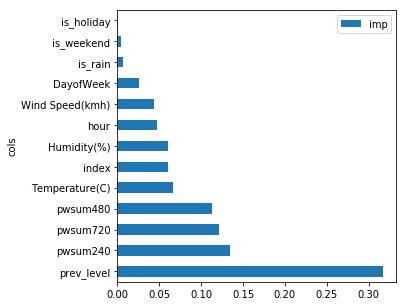

In [184]:
# calculate feature of importance
fi = rf_feat_importance(m, X_trn)
fi.plot('cols','imp',kind='barh',figsize=(5,5))

In [165]:
fi

,cols,imp
4,prev_level,0.323414
9,pwsum240,0.138345
10,pwsum480,0.123892
11,pwsum720,0.108955
5,Temperature(C),0.063688
12,index,0.059198
6,Humidity(%),0.058223
3,hour,0.045567
7,Wind Speed(kmh),0.042406
2,DayofWeek,0.025733


In [190]:
# custom made feature of importance based on permutation method
def feat_importance(m, x_trn, y_trn, metric=accuracy_score):
    """ Computes the feature importance for any model
    m is the model
    x_trn is the training data
    metric is the accuracy_score
    """
    baseline = metric(y_trn, m.predict(x_trn))
    imp = []
    imp_std = []
    for col in x_trn.columns:
        tempt = x_trn.copy()
        shuffle = []
        # ten iteration to get better statistic
        for i in range(10):
            tempt[col] = np.random.RandomState(seed=42).permutation(tempt[col])
            shuffle_score = metric(y_trn, m.predict(tempt))
            shuffle.append(-(baseline - shuffle_score)/baseline)
        imp.append(np.mean(shuffle))
        imp_std.append(np.std(shuffle))
    fea_imp = pd.DataFrame({'cols': x_trn.columns, 'imp':imp,'imp_std':imp_std})
    return fea_imp.sort_values('imp', ascending=False)

In [191]:
#Calculate feature of importance
fi_per = feat_importance(m, X_trn, y_trn, mean_squared_error)
fi_per

,cols,imp,imp_std
4,prev_level,10360.231379,86.640301
9,pwsum240,3663.914932,30.175772
11,pwsum720,2555.173600,17.249399
10,pwsum480,2458.169003,26.306646
6,Humidity(%),2190.709025,36.514060
7,Wind Speed(kmh),2098.377868,22.565992
2,DayofWeek,2082.283442,20.760745
3,hour,1924.181187,15.928363
5,Temperature(C),1859.503208,23.114737
12,index,1635.409086,24.674648


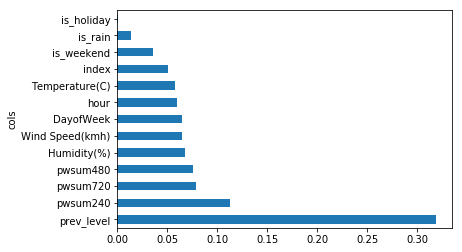

In [200]:
# use the normalized feature of importance
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()
fi_per.plot('cols', 'imp', 'barh', legend=False)

For the first four features, permutation-based feature of importance is in agreement with the build-in function. They disagree on the later parts. Looking at the result, I tend to agree with my custom function.

Another reason to use my own feature of importance function is that I can reuse this later after I obtain the best model from TPOT.

In [201]:
fi_per

,cols,imp,imp_std
4,prev_level,0.319298,86.640301
9,pwsum240,0.112920,30.175772
11,pwsum720,0.078749,17.249399
10,pwsum480,0.075760,26.306646
6,Humidity(%),0.067517,36.514060
7,Wind Speed(kmh),0.064671,22.565992
2,DayofWeek,0.064175,20.760745
3,hour,0.059302,15.928363
5,Temperature(C),0.057309,23.114737
12,index,0.050403,24.674648


In [206]:
# drop features with low importance 
to_drop = fi_per[fi_per.imp <0.05].cols
df_drop = df.drop(to_drop,axis=1)

In [207]:
df_drop.head()

,DayofWeek,hour,prev_level,Temperature(C),Humidity(%),Wind Speed(kmh),pwsum240,pwsum480,pwsum720,index
0,4,16,44,33.89,46.0,14.48,8651.7,26843.5,30974.5,7.1
1,4,17,42,33.89,46.0,12.87,8651.7,26843.5,30974.5,8.2
2,4,18,41,32.22,55.0,14.48,8651.7,26843.5,30974.5,8.8
3,4,19,40,30.00,62.0,14.48,8651.7,26843.5,30974.5,8.6
4,4,20,39,28.89,70.0,14.48,8651.7,26843.5,30974.5,7.3


In [214]:
idx = 17661
X_trn = df_drop.iloc[:idx]
X_val = df_drop.iloc[idx:]

y_trn = y[:idx]
y_val = y[idx:]

In [215]:
# with some feature drop
m = RandomForestRegressor(n_estimators=100, 
                          min_samples_split= 2,
                          min_samples_leaf= 1,
                          max_features= 1,
                          max_depth= None, bootstrap= False, 
                          n_jobs=-1)
m.fit(X_trn, y_trn)
res = print_score(m)

[0.009625729007417474, 64.71203315355869, 0.9999513344534228, 0.6825143058699685]


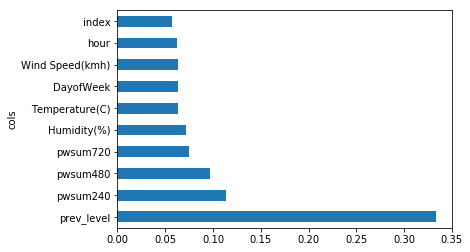

In [216]:
#Calculate feature of importance
fi_per = feat_importance(m, X_trn, y_trn, mean_squared_error)
# normalize feature of importance
fi_per['imp'] = fi_per['imp']/fi_per['imp'].sum()
fi_per.plot('cols', 'imp', 'barh', legend=False)

List features to put in TPOT for searching. 

In [217]:
df_drop.columns

Index(['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'pwsum240', 'pwsum480', 'pwsum720', 'index'],
      dtype='object')

In [219]:
# save the rf model
from joblib import dump, load
dump(m, 'data/model/rfmodel.joblib') 

['data/model/rfmodel.joblib']

In [ ]:
m = load('data/model/rfmodel.joblib')

In [6]:
df_drop = bkkpm_combo[['DayofWeek', 'hour', 'prev_level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'pwsum240', 'pwsum480', 'pwsum720', 'index']]

In [14]:
df_drop.columns = ['DayofWeek', 'hour', 'previous\n PM2.5 level', 'Temperature(C)', 'Humidity(%)',
       'Wind Speed(kmh)', 'hot spots 240 km', 'hot spots 480 km', 'hot spots 720 km', 'traffic index']

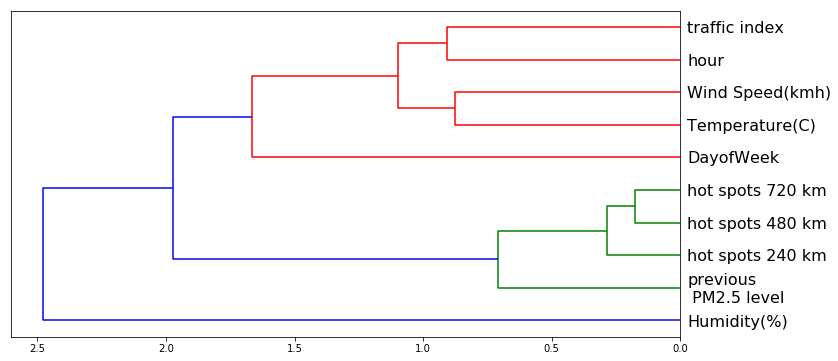

In [17]:
# Redundant Features
corr = np.nan_to_num(np.round(scipy.stats.spearmanr(df_drop).correlation, 4))

for i in range(corr.shape[0]):
    corr[i,i] = 1

corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr, method='average')
fig = plt.figure(figsize=(12,6))
dendrogram = hc.dendrogram(z, labels=df_drop.columns, orientation='left', leaf_font_size=16)
plt.show()

## Model pipline from TPOT

In [15]:
cv = TimeSeriesSplit(n_splits=5)

177 176
353 176
529 176
705 176
881 176


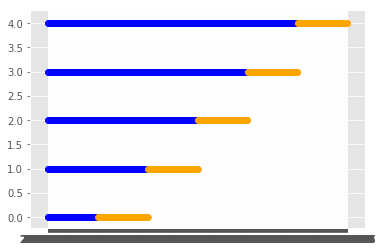

In [609]:
for i, (day_trn,day_val) in enumerate(cv.split(date.values.reshape([-1,1]))):
    print(len(day_trn),len(day_val))
    plt.scatter(x=date[day_trn], y=i*np.ones(len(day_trn)), color='blue')
    plt.scatter(x=date[day_val], y=i*np.ones(len(day_val)), color='orange')
   

In [16]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_trn), y_trn), rmse(m.predict(X_val), y_val),
                m.score(X_trn, y_trn), m.score(X_val, y_val)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    return res

In [95]:
X_trn = df.iloc[:808]
X_val = df.iloc[808:951]
X_test = df.iloc[951:]

y_trn = y[:808]
y_val = y[808:951]
y_test = y[951:]

In [102]:
#baseline
m = RandomForestRegressor(n_estimators=100,min_samples_leaf= 2, 
                          max_features= 'sqrt', max_depth= None,
                          n_jobs=-1, oob_score=True)
m.fit(X_trn, y_trn)
res = print_score(m)

[3.8882607440965753, 4.383857202568584, 0.9001273789753937, 0.5641231407536107, 0.6738873548176076]


In [98]:
param_dist = {'n_estimators':range(10,70,10),
              'max_depth': [3, None],
              'max_features': [0.5, 1, 'log2','sqrt','auto'],
              'min_samples_leaf': range(1, 8)}

In [99]:
search = RandomizedSearchCV(m, param_distributions=param_dist,n_iter=30,n_jobs=-1, cv=5)

In [100]:
search.fit(X_trn,y_trn)

C:\Users\Benny\Anaconda3\envs\fastai\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=1, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=True, random_state=None,
           verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=30, n_jobs=-1,
          param_distributions={'n_estimators': range(10, 70, 10), 'max_depth': [3, None], 'max_features': [0.5, 1, 'log2', 'sqrt', 'auto'], 'min_samples_leaf': range(1, 8)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [101]:
search.best_params_, search.best_score_

({'n_estimators': 40,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'max_depth': None},
 0.4307314382743047)

In [81]:
fi = rf_feat_importance(m, X_trn)

In [82]:
fi

,cols,imp
3,DayofYear,0.136870
5,weekofyear,0.111825
10,Dew Point(C),0.083256
13,Pressure(mm),0.081062
8,Humidity(%),0.079327
2,month,0.076603
11,Wind Speed(kmh),0.062988
17,Wind,0.062301
1,quarter,0.061606
9,Temperature(C),0.047758
